##  Laboratory Task 5
## Machine Learning Technologies

**ITMO university. 1st semester**

Performed by: Gleb Mikloshevich

Group: J4132C

---

Course: MLT September

Lecturer: Petr Gladilin



links:

model: https://huggingface.co/google/vit-base-patch16-224

guide: https://huggingface.co/blog/fine-tune-vit

In [ ]:
!pip install datasets transformers evaluate accelerate
!pip install accelerate -U

In [32]:
import albumentations as A
import cv2
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import classification_report, accuracy_score
import os
import torch
import numpy as np
from datasets import load_dataset, load_metric
from evaluate import load
import accelerate
from google.colab import drive
import matplotlib.pyplot as plt


# Preprocessing

In [3]:
SIZE = (224, 224)

## Data loading

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip ./drive/MyDrive/datasets_itmo/Cats_and_Dogs.zip -d ./

Loading and resizing is a long operationg so I did it here to speedup the training

In [6]:
data_folder = "resized"
original_folder = "Cats_and_Dogs"
data_splits = ["test", "train", "val"]
data_classes = ["cats", "dogs"]

In [7]:
!rm -rf ./resized

In [8]:
for data_split in data_splits:
    for data_class in data_classes:
        os.makedirs(f"./{data_folder}/{data_split}/{data_class}")
        for file_name in os.listdir(f"./{original_folder}/{data_split}/{data_class}"):
            if file_name != "desktop.ini":
                img = Image.open(f"./{original_folder}/{data_split}/{data_class}/{file_name}")
                img = img.resize(SIZE, Image.Resampling.LANCZOS)
                img.save(f"./{data_folder}/{data_split}/{data_class}/{file_name}")



In [9]:
data = load_dataset(".", data_dir="resized")

Resolving data files:   0%|          | 0/20000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2490 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2500 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [10]:
print(data)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2490
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2500
    })
})


The train dataset have 20_000 images. It's big enough to train without augmentations to speed up the training process.

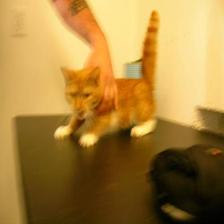

In [11]:
# example image
data["train"]["image"][0]

In [12]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224',
                                                  num_labels=2,
                                                  ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['label']
    return inputs

In [14]:
def transform(examples):
    inputs = processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")
    inputs["labels"] = examples["label"]
    return inputs
dataset = data.with_transform(transform)

In [15]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-15-a00513a56fba>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


# Model training

In [19]:
training_args = TrainingArguments(
  output_dir="./model_output",
  per_device_train_batch_size=100,
  evaluation_strategy="steps",
  num_train_epochs=7,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  report_to='tensorboard',
  load_best_model_at_end=True,
  remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=processor,
)

In [20]:
res = trainer.train()
trainer.save_model()
trainer.log_metrics("train", res.metrics)
trainer.save_metrics("train", res.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =           7.0
  total_flos               = 10103805499GF
  train_loss               =        0.0101
  train_runtime            =    0:52:50.33
  train_samples_per_second =        44.159
  train_steps_per_second   =         0.442


training loss is almost zero after 900 steps. The training stopped

In [30]:
loss = []
loss_x = []
eval_loss = []
eval_x = []
for obj in trainer.state.log_history:
    if "loss" in obj:
        loss.append(obj["loss"])
        loss_x.append(obj["epoch"])
    if "eval_loss" in obj:
        eval_loss.append(obj["eval_loss"])
        eval_x.append(obj["epoch"])

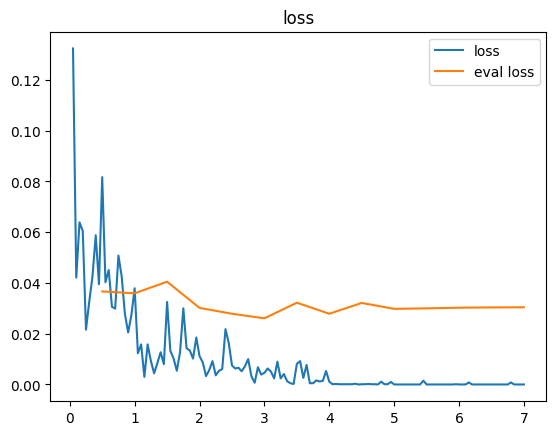

In [36]:
plt.plot(loss_x, loss, label="loss")
plt.plot(eval_x, eval_loss, label="eval loss")
plt.title("loss")
plt.legend(loc="best")
plt.show()

In [21]:
preds = trainer.predict(dataset["test"])

In [22]:
preds = np.argmax(preds[0],axis=1)

In [23]:
y_test = [dataset["test"][i]["labels"] for i in range(len(dataset["test"]))]

In [24]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1245
           1       0.99      0.99      0.99      1255

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



In [25]:
print(f"accuracy: {accuracy_score(preds, y_test)}")

accuracy: 0.9884
